In [1]:
#@title Setting up environment
from google.colab import output

!git clone https://github.com/Quiexx/SpaceFace.git

!pip install click requests tqdm pyspng imageio-ffmpeg==0.4.3

!pip install torch==1.7.1

!pip install huggingface_hub

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd SpaceFace

output.clear()
print("Environment is set up")

Environment is set up


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Imports

import pickle
import torch
import PIL
import numpy as np
import math
import os
from huggingface_hub import hf_hub_download
import cv2
from IPython.display import HTML
from base64 import b64encode
from typing import List

def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

def to_mp4(frames: List[PIL.Image.Image], name: str, frame_count: int) -> str:
  if os.path.exists(name):
    os.remove(name)
  
  images = [cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) for img in frames]
  height, width, layers = images[0].shape
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  video = cv2.VideoWriter(name, fourcc, frame_count, (width, height))
  
  for image in images:
      video.write(image)

  video.release()
  video_h264_path = name.split(".")[-2] + "_h264.mp4"
  if os.path.exists(video_h264_path):
    os.remove(video_h264_path)

  os.system(f"ffmpeg -i {name} -vcodec libx264 {video_h264_path}")
  return video_h264_path

def show_mp4(video_path: str) -> None:
  mp4 = open(video_path, "rb").read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
    <video width=400 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
  """)

def add_imgs(images):
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
  return new_im

def show_many_mp4(video_paths: List[str]) -> None:
  html_string = ""
  for v_path in video_paths:
    mp4 = open(v_path, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html_string += f"""
    <video width=400 controls loop="loop" autoplay="autoplay">
        <source src="{data_url}" type="video/mp4">
    </video>\n
    """
  return HTML(html_string)

In [3]:
#@title Load network from huggingface

model_repo = "Quiexx/SpaceFace" #@param {type:"string"}
model_name = "space_face.pkl" #@param {type: "string"}

model_path = hf_hub_download(model_repo, model_name)

%cd stylegan2-ada-pytorch

with open(model_path, "rb") as f:
  model = pickle.load(f)

%cd ..

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

/content/SpaceFace/stylegan2-ada-pytorch
/content/SpaceFace


		seed 11928977230525635755			seed 11106372467401869981			 seed 10195259225269088315


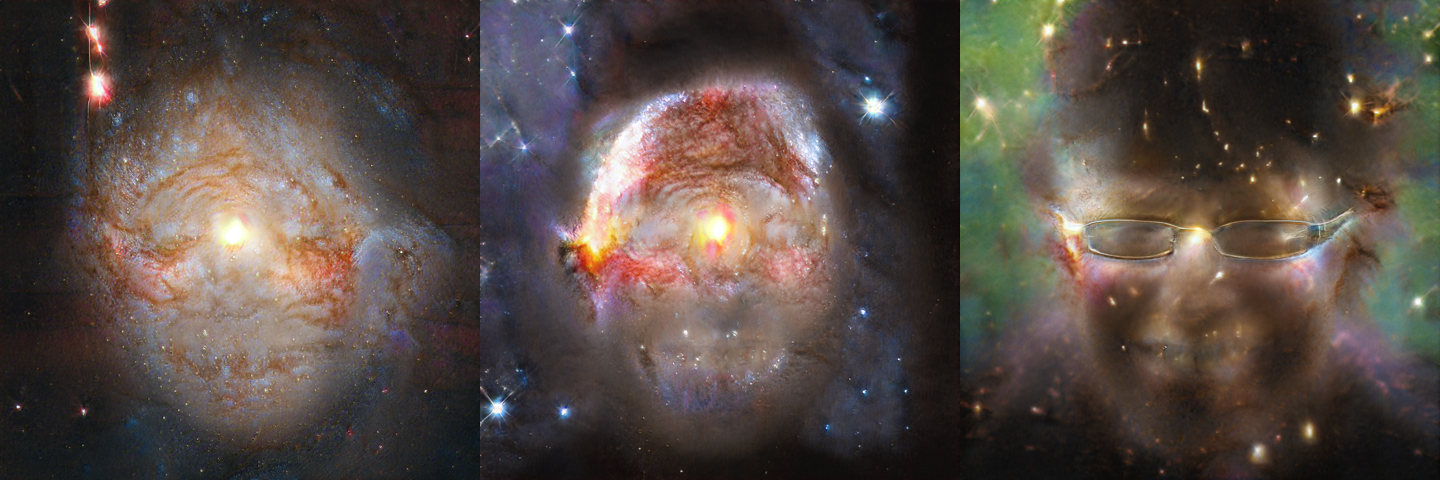

In [7]:
#@title Generate images
#@markdown If seed is None, then torch.seed() is used

#@markdown Interesting seeds:

#@markdown 4626299924788034287

#@markdown 3216877905852843512


seed =  None#@param

if seed is not None:
  torch.manual_seed(seed)

  z = torch.randn([1, model.z_dim]).cuda() 
  c = None 
  w = model.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
                            
  img = model.synthesis(w, noise_mode='const', force_fp32=True)
  print(f"Seed: {seed}")
  display(t2i(img).resize((480, 480)))

else:
  imgs = []
  seeds = []
  for i in range(3):
    seed = torch.seed()
    seeds.append(seed)

    z = torch.randn([1, model.z_dim]).cuda() 
    w = model.mapping(z, None, truncation_psi=0.5, truncation_cutoff=8)
                            
    img = model.synthesis(w, noise_mode='const', force_fp32=True)
    imgs.append(t2i(img).resize((480, 480)))
  
  grid = add_imgs(imgs)
  print("\t\tseed {}\t\t\tseed {}\t\t\t seed {}".format(*seeds))
  display(grid)

In [8]:
#@title Set seed

seed = 10195259225269088315#@param
torch.manual_seed(seed)
z = torch.randn([1, model.z_dim]).cuda() 
w = model.mapping(z, None, truncation_psi=0.5, truncation_cutoff=8)

In [9]:
#@title Loading directions

eyes_open = torch.from_numpy(np.load('directions/eyes_open.npy').astype(np.float32)).cuda()
lip_ratio = torch.from_numpy(np.load('directions/lip_ratio.npy').astype(np.float32)).cuda()
pitch = torch.from_numpy(np.load('directions/pitch.npy').astype(np.float32)).cuda()
yaw = torch.from_numpy(np.load('directions/yaw.npy').astype(np.float32)).cuda()

def mix_with_directions(source: torch.Tensor, directions: torch.Tensor, weights: float) -> torch.Tensor:
    latent = source.clone()
    for d, w in zip(directions, weights):
        latent += d * w
    return latent

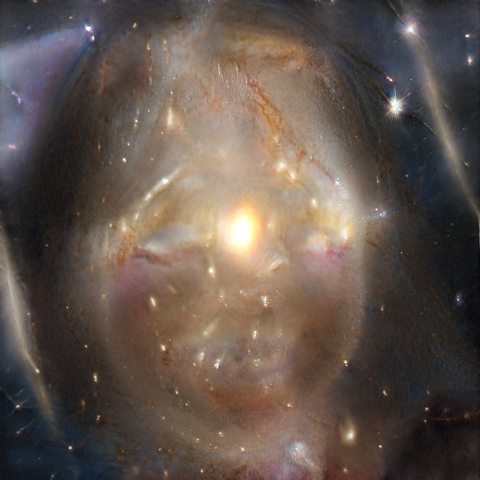

In [7]:
#@title Directions

w_eyes_open = -20 #@param {type:"slider", min:-20, max: 20, step:1}
w_lip_ratio = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_pitch = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_yaw = 0 #@param {type:"slider", min:-10, max: 10, step:1}

latent = mix_with_directions(w, [eyes_open, lip_ratio, pitch, yaw], [w_eyes_open, w_lip_ratio, w_pitch, w_yaw])

img = model.synthesis(latent, noise_mode='const', force_fp32=True)

img = t2i(img)
img.resize((480, 480))

In [10]:
#@title Prepared animations

def h_rotation(frame_count):
  frames = []
  yaw_from =  -10
  yaw_to =  10
  yaw_step = (yaw_to - yaw_from) / (frame_count // 2)

  for frame_number in range(frame_count // 2):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [yaw], [w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  return frames

def diagonal_rotation(frame_count):
  pitch_from = -10
  pitch_to = 10

  yaw_from = -10
  yaw_to = 10
  yaw_step = (yaw_to - yaw_from) / (frame_count // 2)
  pitch_step = (pitch_to - pitch_from) / (frame_count // 2)
  
  frames = []

  for frame_number in range(frame_count // 2):
    w_yaw = yaw_from + frame_number * yaw_step
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  return frames

def square_rotation(frame_count):
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = -10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  w_pitch = 10
  yaw_from, yaw_to = -10, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = 10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  w_pitch = -10
  yaw_from, yaw_to = 10, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  return frames

def rhomb_rotation(frame_count):
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage

  yaw_from, yaw_to = 0, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage


  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  pitch_from, pitch_to = 0, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = -10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 0, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  pitch_from, pitch_to = 0, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  return frames

def blinking(frame_count):
  open_eyes_to = -30
  open_eyes_from = 30
  frames = []
  frames_per_stage = frame_count // 2

  open_eyes_step = (open_eyes_to - open_eyes_from) / frames_per_stage

  for stage in range(1):
    stage_frames = []
    for frame_number in range(frames_per_stage):
      w_eyes_open = open_eyes_from + frame_number * open_eyes_step

      latent = mix_with_directions(w, [eyes_open], [w_eyes_open])

      img = model.synthesis(latent, noise_mode='const', force_fp32=True)
      img = t2i(img)

      stage_frames.append(img)

    stage_frames.extend(stage_frames[::-1])
    frames.extend(stage_frames)
  return frames

def circle_rotation(frame_count):
  angle_step = 2 * math.pi / frame_count
  angles = [i * angle_step for i in range(frame_count)]
  frames = []
  R = 10

  for angle in angles:
    w_pitch = R * math.sin(angle)
    w_yaw = R * math.cos(angle)

    latent = mix_with_directions(w, [w_pitch, w_yaw], [pitch, yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  return frames
  

anims = {"1": h_rotation, 
         "2": diagonal_rotation, 
         "3": square_rotation, 
         "4": rhomb_rotation,
         "5": blinking,
         "6": circle_rotation}

In [11]:
#@title Create animations
#@markdown 1: horizontal rotation

#@markdown 2: diagonal rotation

#@markdown 3: rotation in a square

#@markdown 4: rotation in a rhomb

#@markdown 5: blinking

#@markdown 6: rotation in a circle

fps =  30#@param {"type": "integer"}
duration =  4#@param {"type": "integer"}
frame_count = fps * duration

#@markdown List of animation types to create
anim_types = [1, 2, 5, 6] #@param {}

anim_dir = "animations"
if os.path.isdir(anim_dir):
  for f in os.listdir(anim_dir):
    os.remove(os.path.join(anim_dir, f))
else:
  os.mkdir(anim_dir)
         
animation_paths = []

for anim_type in anim_types:
  anim_func = anims[str(anim_type)]
  frames = anim_func(frame_count)
  save_path = os.path.join(anim_dir, anim_func.__name__ + ".mp4")
  to_show_path = to_mp4(frames, save_path, fps)
  animation_paths.append(to_show_path)

print("Animations created!")

In [12]:
#@title Show animations
show_many_mp4(animation_paths)

In [15]:
#@title Save gif

anim_type = "2" #@param {type: "string"}
save_path = "../drive/MyDrive/spaceface_example_opt.gif" #@param {type: "string"}
fps = 15  #@param {type: "integer"}
duration = 4  #@param {type: "integer"}
resolution =  256#@param {type: "integer"}
optimize = True #@param {type: "boolean"}
frame_count = fps * 4

frames = anims[anim_type](frame_count)
sized_frames = [frame.resize((resolution, resolution)) for frame in frames]
sized_frames[0].save(save_path, 
               save_all=True, 
               append_images=sized_frames[1:], 
               duration=duration * 1000 // frame_count, 
               loop=0, 
               optimize=optimize)